In [23]:
import sys, os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('backbone')))) # to import file from under same-level directory
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('utils'))))
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('neck'))))

from backbone.convnext_se.convnext_se import ConvNextV1, Stage, Stem
from utils.conv_2d import adjust_padding_for_strided_output, DepthWiseSepConv
from utils.stochastic_depth_drop import create_linear_p, create_uniform_p
from neck.convnext_se_fpn import DetectorBackbone, FPN

import os
import glob
import PIL
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
import torchinfo
import albumentations
import pprint


In [12]:
ex_img = Image.open("/work/dataset/CULane/driver_193_90frame/06051132_0638.MP4/00000.jpg")
print("original image size: ", ex_img.size)
# detector also will have much smaller image scale than original image
ex_img_resize = ex_img.resize([672, 224])
ex_img = torch.tensor(np.array(ex_img_resize)).unsqueeze(0).permute(0, 3, 1, 2).float().to('cuda')
print(ex_img.shape)

original image size:  (1640, 590)
torch.Size([1, 3, 224, 672])


In [13]:
dp_list, dp_mode = create_linear_p([3,3,9,3], 'batch', 0.25) # creates linearly decaying stochastic depth drop rate and mode

detector_encoder = DetectorBackbone(num_blocks=[3,3,9,3], input_channels=3, stem_kersz=(4,4), stem_stride=(4,4), 
                                   img_hw=[(56, 168), (28, 84), (14, 42), (7,21)], main_channels=[48, 96, 192, 384], expansion_dim=[48*4, 96*4, 192*4, 384*4], 
                                   kernel_sz=[(7,7)]*4, stride=[(1,1)]*4, padding=['same']*4, dilation=[1]*4, groups=[1]*4, droprate=dp_list, drop_mode=dp_mode, 
                                   use_se=[True]*4, squeeze_ratio=16, transition_kersz=[-1, (1,1), (1,1), (1,1)], transition_stride=[-1, (2,2), (2,2), (2,2)], norm_mode='layer_norm', device='cuda')

# fpn has the structure that goes through 0 to 3 stage output, we can use corresponding (28, 84), (14, 42), (7, 21) stage output,
# or we can use all stages output to constructure fpn structure.
backbone_o = detector_encoder(ex_img)
for i, stage in enumerate(backbone_o):
    print(f"each stage output {i}: ", stage.shape)

torchinfo.summary(detector_encoder, (1, 3, 224, 672))

each stage output 0:  torch.Size([1, 48, 56, 168])
each stage output 1:  torch.Size([1, 96, 28, 84])
each stage output 2:  torch.Size([1, 192, 14, 42])
each stage output 3:  torch.Size([1, 384, 7, 21])


Layer (type:depth-idx)                             Output Shape              Param #
DetectorBackbone                                   [1, 48, 56, 168]          --
├─Stem: 1-1                                        [1, 48, 56, 168]          --
│    └─Conv2d: 2-1                                 [1, 48, 56, 168]          2,352
├─ModuleList: 1-2                                  --                        --
│    └─Stage: 2-2                                  [1, 48, 56, 168]          --
│    │    └─ModuleList: 3-1                        --                        2,780,793
│    └─Stage: 2-3                                  [1, 96, 28, 84]           --
│    │    └─ModuleList: 3-2                        --                        1,621,170
│    └─Stage: 2-4                                  [1, 192, 14, 42]          --
│    │    └─ModuleList: 3-3                        --                        5,153,580
│    └─Stage: 2-5                                  [1, 384, 7, 21]           --
│    │    └

In [14]:
# class FPN(torch.nn.ModuleList):
#     def __init__(self, nstage_to_use, bidirectional, in_channels, out_channels, img_hw, downsample_kersz, upsample_kersz, downsample_stride, upsample_stride, 
#                  downsample_dilation, upsample_dilation, downsample_groups, upsample_groups, upsample_padding, upsample_out_padding, norm_mode, device, dtype):

fpn = FPN(nstage_to_use=4, bidirectional=True, in_channels=[48, 96, 192, 384], out_channels=224, img_hw=[(56, 168), (28, 84), (14, 42), (7, 21)],
          downsample_kersz=[(7,7), (7,7), (7,7)], upsample_kersz=[(7,7), (7,7), (7,7)], downsample_stride=[(2,2), (2,2), (2,2)], upsample_stride=[(2,2), (2,2), (2,2)],
          downsample_dilation=[1,1,1], upsample_dilation=[1,1,1], downsample_groups=[1,1,1], upsample_groups=[1,1,1], 
          upsample_padding=[(3,3), (3,3), (3,3)], upsample_out_padding=[(1,1), (1,1), (1,1)], norm_mode='layer_norm', device='cuda', dtype=None)
fpn_output = fpn(backbone_o)
for i in range(len(fpn_output)):
    print(f"{i}th fpn output shape: ", fpn_output[i].shape)

0th fpn output shape:  torch.Size([1, 224, 7, 21])
1th fpn output shape:  torch.Size([1, 224, 14, 42])
2th fpn output shape:  torch.Size([1, 224, 28, 84])
3th fpn output shape:  torch.Size([1, 224, 56, 168])


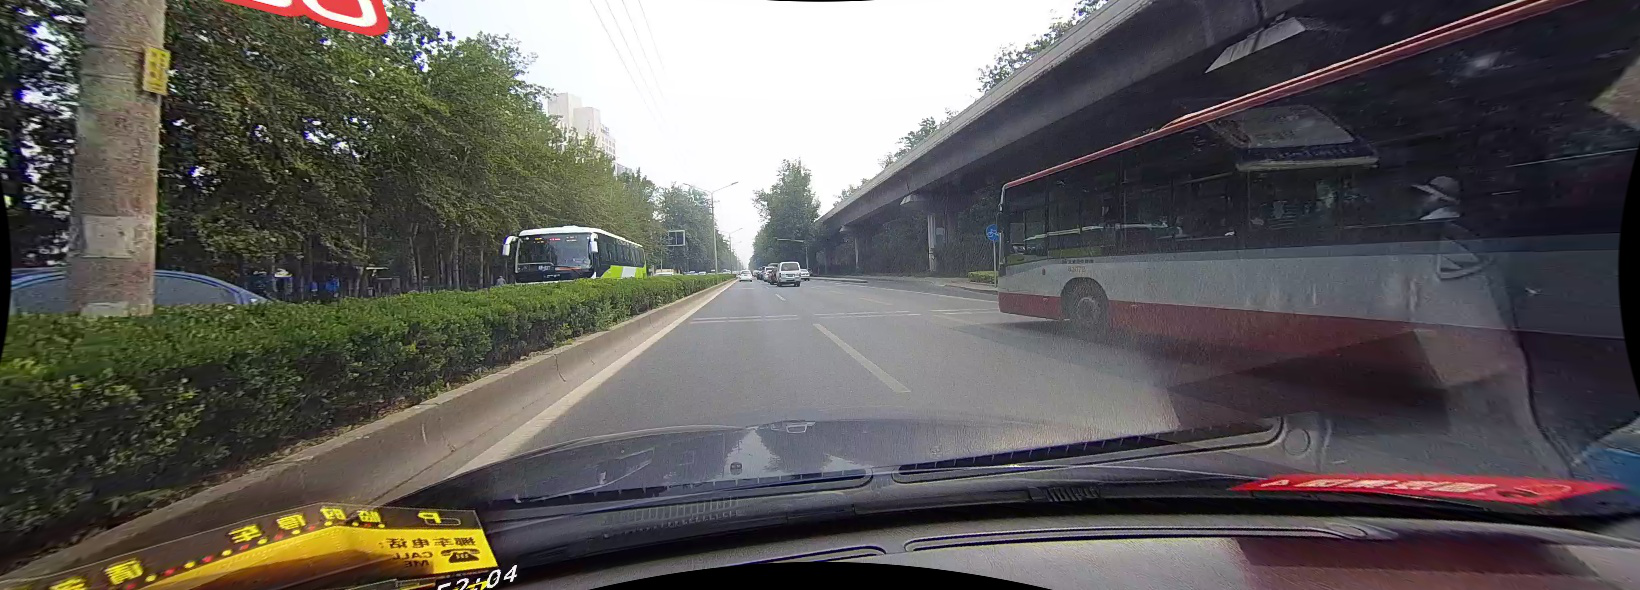

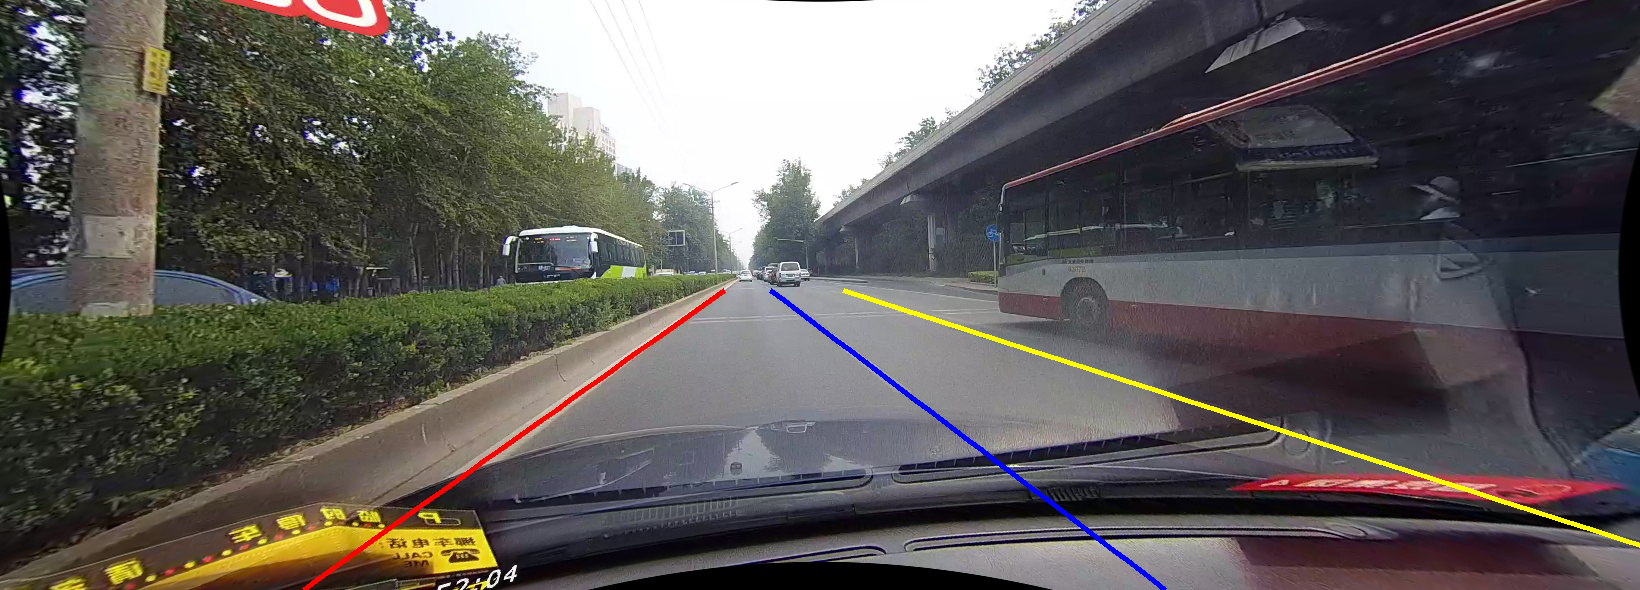

In [30]:
vis_img = Image.open('/work/dataset/CULane/driver_193_90frame/06061052_0851.MP4/00000.jpg')
vis_img.show()
with open('/work/dataset/CULane/driver_193_90frame/06061052_0851.MP4/00000.lines.txt', 'r') as fr:
    vis_img_gt = fr.readlines()
for i in range(len(vis_img_gt)):
    vis_img_gt[i] = vis_img_gt[i].strip()
    

def draw_lanes(image, labels):
    color_list = ['red', 'blue', 'yellow', 'black']
    draw = ImageDraw.Draw(image)
    lines = []
    for p_set in labels:
        points = []
        tokens = p_set.split(' ')
        for token in tokens:
            points.append(float(token))
        lines.append(points)
    
    lines_p = []
    for line in lines:
        t = []
        for i in range(0, len(line), 2):
            t.append((line[i], line[i+1])) # pair x, y point locations
        lines_p.append(t)
    
    for lane_index, line in enumerate(lines_p, 0):
        for i in range(len(line)-1):
            draw.line((line[i][0], line[i][1], line[i+1][0], line[i+1][1]), fill=color_list[lane_index], width=5)
    
    return image

lane_img = draw_lanes(vis_img, vis_img_gt)
lane_img.show()

In [15]:
# head of the network: 
class LaneHead(torch.nn.Module):
    def __init__(self, in_channels, nstages, device, dtype=None):
        self.in_channels = in_channels  # number of channels from FPN output
        self.nstages = nstages          # number of stages from FPN
        self.device = device            # 'cuda' or 'cpu'
        self.dtype = dtype              # default to None
        
        
        
        

In [31]:
# retinanet network head (anchors boxes are used)
class RetinaHead(torch.nn.Module):
    def __init__(self, in_channels, num_cls, num_anchors, nstages, branch_len, branch_kersz, branch_dilation, branch_groups, device, dtype):
        super().__init__()
        self.in_channels = in_channels       # number of input channels for head
        self.num_cls = num_cls               # number of class for classification branch
        self.nstages = nstages               # number of stages of input
        self.branch_len = branch_len         # number of iterations for head branch
        self.num_anchors = num_anchors       # number of anchors
        
        self.branch_kersz = branch_kersz        # kernel size in each branch convolution
        self.branch_dilation = branch_dilation  # dilation value (ratio of expansion) in each branch convolution
        self.branch_groups = branch_groups      # number of groups in each branch convolution
        
        self.device = device
        self.dtype = dtype
        
        # weight of the regression branches all shared across stages
        self.regression_branch = []
        for i in range(self.branch_len):
            self.regression_branch.append(torch.nn.Conv2d(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=self.branch_kersz, stride=(1,1), 
                                                          padding='same', dilation=self.branch_dilation, groups=self.branch_groups, device=self.device, dtype=self.dtype))
            self.regression_branch.append(torch.nn.ReLU())
        self.regression_branch = torch.nn.ModuleList(self.regression_branch)
            
        # weight of the classification branches all shared across stages
        self.cls_branch = []
        for i in range(self.branch_len):
            self.cls_branch.append(torch.nn.Conv2d(in_channels=self.in_channels, out_channels=self.in_channels, kernel_size=self.branch_kersz, stride=(1,1),
                                                   padding='same', dilation=self.branch_dilation, groups=self.branch_groups, device=self.device, dtype=self.dtype))
            self.cls_branch.append(torch.nn.ReLU())
        self.cls_branch = torch.nn.ModuleList(self.cls_branch)
        
        # (center_x, center_y, width, height) normalized version
        self.regression_out = torch.nn.Conv2d(in_channels=self.in_channels, out_channels=4 * self.num_anchors, kernel_size=(1,1), stride=(1,1),
                                              padding='same', dilation=1, groups=1, device=self.device, dtype=self.dtype)
        
        # number of classes * self.num_anchors for all tiled location
        self.cls_out = torch.nn.Conv2d(in_channels=self.in_channels, out_channels=self.num_cls * self.num_anchors, kernel_size=(1,1), stride=(1,1),
                                       padding='same', dilation=1, groups=1, device=self.device, dtype=self.dtype)
        self.cls_act = torch.nn.Softmax2d()
    
    # example fpn output): [(224,7,21), (224,14,42), (224,28,84), (224,56,168)]
    def forward(self, fpn_o):
        reg_x = fpn_o
        cls_x = fpn_o
        
        reg_o = [] # list of regression output
        cls_o = [] # list of clssification output
        
        for fpn_stage_o in fpn_o: # for each stage output corresponding to fpn_o
            reg_x = fpn_stage_o
            cls_x = fpn_stage_o
            for i in range(self.branch_len):
                reg_x = self.regression_branch[2*i](reg_x)
                reg_x = self.regression_branch[2*i+1](reg_x)
                
                cls_x = self.cls_branch[2*i](cls_x)
                cls_x = self.cls_branch[2*i+1](cls_x)
            
            reg_o.append(self.regression_out(reg_x))
            cls_o.append(self.cls_act(self.cls_out(cls_x)))
        
        return reg_o, cls_o

: 